# Grade Clustering
This script is used for clustering learners in each group based their weekly grades. (Clustering method is KMeans which uses dynamic time warping (DTW) algorithm to measure the distances between two learners' weekly grades. Currently the algorithm is based on [a github project](https://github.com/alexminnaar/time-series-classification-and-clustering) for classification and clustering time-series data. This project uses and extends the method of [UCR time-series classification](http://www.cs.ucr.edu/~eamonn/time_series_data/))

In [2]:
import pandas as pd
import numpy as np

from math import pi
from math import *

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import fclusterdata
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm

import random
import os

## Data Selection

In [53]:
# Output folder
outputfolderpath = "clusterbygrade/"
if not os.path.exists(outputfolderpath):
    os.makedirs(outputfolderpath)

# config
group = 'Week_7'

csv_file='FP101x_3T2015_grade_distribution.csv'
# FP group: Week_5, Week_6, Week_7

# csv_file='EX101x_3T2015_grade_distribution.csv'
# # EX group: Week_5, Week_6, Week_7

# csv_file='RI101x_1T2016_grade_distribution.csv'
# # RI group: Week_4, Week_5, Week_6

# csv_file='CTB3365STx_1T2016_grade_distribution.csv'
# # # CTB group: Week_4, Week_5, Week_6

In [54]:
# load data
df = pd.read_csv(csv_file)
coursetitle = csv_file.split("_")[0] + "_" + csv_file.split("_")[1]
print df.head(10)

                        course_learner_id     score   group rel_week
0  course-v1:DelftX+FP101x+3T2015_1001841  1.000000  Week_5   Week_1
1  course-v1:DelftX+FP101x+3T2015_1001841  1.000000  Week_5   Week_2
2  course-v1:DelftX+FP101x+3T2015_1001841  1.000000  Week_5   Week_3
3  course-v1:DelftX+FP101x+3T2015_1001841  1.000000  Week_5   Week_4
4  course-v1:DelftX+FP101x+3T2015_1001841  1.000000  Week_5   Week_5
5  course-v1:DelftX+FP101x+3T2015_1001841  1.000000  Week_5   Week_6
6  course-v1:DelftX+FP101x+3T2015_1001841  0.980000  Week_5   Week_7
7  course-v1:DelftX+FP101x+3T2015_1001841  1.000000  Week_5   Week_8
8  course-v1:DelftX+FP101x+3T2015_1004052  0.777778  Week_5   Week_1
9  course-v1:DelftX+FP101x+3T2015_1004052  0.933333  Week_5   Week_2


In [55]:
# select the current week group
df_w=df[df['group']==group]
# get rid of group column
df_w=df_w.drop('group',1)
# replace these silly categorial labels with numeric values to allow for statistical analysis....
cat_labels = ['Week_1', 'Week_2', 'Week_3', 'Week_4', 'Week_5', 'Week_6', 'Week_7', 'Week_8']
df_wn=df_w.replace(to_replace=cat_labels, value=[1, 2, 3, 4 ,5, 6, 7, 8])
# create a proper featureset using a pivot for each learner
# result: dataframe with learner ID as index column, and scores for each week as data columns. One row per learner. 
learner_features_dtw = df_w.pivot(index='course_learner_id', columns='rel_week', values='score')
learner_features = df_w.pivot(index='course_learner_id', columns='rel_week', values='score')
print learner_features_dtw.head(10)

rel_week                                  Week_1    Week_2    Week_3  \
course_learner_id                                                      
course-v1:DelftX+FP101x+3T2015_1024227  0.666667  0.955556  0.849057   
course-v1:DelftX+FP101x+3T2015_1057358  1.000000  0.866667  0.981132   
course-v1:DelftX+FP101x+3T2015_1078466  0.555556  0.844444  0.849057   
course-v1:DelftX+FP101x+3T2015_113237   0.666667  0.888889  0.830189   
course-v1:DelftX+FP101x+3T2015_1173075  0.666667  0.777778  0.905660   
course-v1:DelftX+FP101x+3T2015_1259440  0.888889  0.888889  0.886792   
course-v1:DelftX+FP101x+3T2015_1386122  0.444444  0.977778  0.830189   
course-v1:DelftX+FP101x+3T2015_1451688  0.888889  0.933333  0.981132   
course-v1:DelftX+FP101x+3T2015_1513058  1.000000  0.422222  0.924528   
course-v1:DelftX+FP101x+3T2015_1524724  0.666667  0.933333  0.981132   

rel_week                                  Week_4    Week_5    Week_6  Week_7  \
course_learner_id                                      

## Clustering Algorithm 1: KMeans

In [56]:
# k-NN Clustering
# This is is very simplistic: Cluster the learner score features using k-NN with k ranging from 2 to 8
# measure the avg silhouette score for each cluster
# select the clustering with the best (highest) avg silhoutte score
# This is NOT very clever as this clustering ignores the fact that we are dealing with time series - here, each weekly score
# is treated as a fully independent dimension.

## What we SHOULD use is something like dynamic tiem warping.

range_n_clusters = [2, 3, 4, 5, 6] # i only go with a max k of 6, because more seemed useless to me.
best_n_clusters = 0
clust = None
best_silhouette_score = 0
for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    # clusterer = AgglomerativeClustering(n_clusters=n_clusters,
    #                                     linkage="average", 
    #                                     affinity=DTWDistance)
    cluster_labels = clusterer.fit_predict(learner_features)
      
    silhouette_avg = silhouette_score(learner_features, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    if (silhouette_avg>best_silhouette_score):
        best_silhouette_score=silhouette_avg
        best_n_clusters=n_clusters
        clust = cluster_labels
   
# select best cluster, add cluster id as new column to learner featues called group
print("Best Cluster ",best_n_clusters)
learner_features['cluster'] = clust

('For n_clusters =', 2, 'The average silhouette_score is :', 0.35386808510033629)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.24855331826012081)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.23382491478039932)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.23829469443945384)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.21249712958429579)
('Best Cluster ', 2)


In [57]:
# learner2group mapping: to which group does each learner belong?
# this is needed for further analysis by dan (demographics of groups), and also for the factor plots
learner2group = pd.DataFrame(learner_features.index.values, columns={'course_learner_id'})
learner2group['cluster'] = clust
clust_value_count = pd.value_counts(learner2group["cluster"].values, sort=False)
print clust_value_count
learner2group["cluster"] = learner2group["cluster"].apply(lambda x: "c" + str(x) + ":" + str(clust_value_count[x]))
learner2group.to_csv(outputfolderpath + coursetitle + "_grade_clust_" + group + ".csv")

0    98
1    85
dtype: int64


                        course_learner_id     score  rel_week cluster
0  course-v1:DelftX+FP101x+3T2015_1024227  0.666667         1   c0:98
1  course-v1:DelftX+FP101x+3T2015_1024227  0.955556         2   c0:98
2  course-v1:DelftX+FP101x+3T2015_1024227  0.849057         3   c0:98
3  course-v1:DelftX+FP101x+3T2015_1024227  0.933333         4   c0:98
4  course-v1:DelftX+FP101x+3T2015_1024227  0.697674         5   c0:98
5  course-v1:DelftX+FP101x+3T2015_1024227  0.000000         6   c0:98
6  course-v1:DelftX+FP101x+3T2015_1024227  0.740000         7   c0:98
7  course-v1:DelftX+FP101x+3T2015_1024227  0.000000         8   c0:98
8  course-v1:DelftX+FP101x+3T2015_1057358  1.000000         1   c1:85
9  course-v1:DelftX+FP101x+3T2015_1057358  0.866667         2   c1:85
7.0


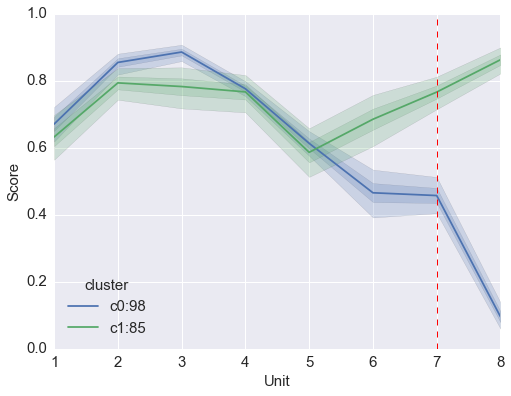

In [58]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# Font Size
SIZE = 15
plt.rc('font', size=SIZE)  # controls default text sizes
plt.rc('axes', titlesize=SIZE)  # fontsize of the axes title
plt.rc('axes', labelsize=SIZE)  # fontsize of the x any y labels
plt.rc('xtick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('ytick', labelsize=SIZE)  # fontsize of the tick labels
plt.rc('legend', fontsize=SIZE)  # legend fontsize
plt.rc('figure', titlesize=SIZE)  # # size of the figure title

# Figure Size
plt.figure(figsize=(640/80, 480/80), dpi=80)

# combine the raw data frame with the group id's discovered by the clustering
clustered_data=df_wn.merge(learner2group, on='course_learner_id')
print clustered_data.head(10)

##setup styles
# sns.set(style="darkgrid")

## the old factorplot with lines
# ax = sns.factorplot(x="rel_week", y="score", hue="group", data=clustered_data, size=8, aspect=1.5)
## and with boxes
# ax = sns.factorplot(kind="box", x="rel_week", y="score", col="group", data=clustered_data, size=8, aspect=1.5)

## time series plot with error bands
# errstyles={'ci_band', 'ci_bars', 'boot_traces', 'boot_kde', 'unit_traces', 'unit_points'}.
ax = sns.tsplot(time="rel_week", unit="course_learner_id", value="score", condition="cluster", 
                 data=clustered_data, err_style={'ci_band'}, ci=[70, 99], interpolate=True)
ax.set(xlabel='Unit', ylabel='Score')
# plt.title(coursetitle+": Passer Group "+str(week))
passweek_x_axis = float(group.split("_")[1])
print passweek_x_axis
plt.plot([passweek_x_axis, passweek_x_axis], [0, 1], 'r', linestyle='--', linewidth=1)
# relweek_uni = clustered_data['rel_week'].unique()
# plt.plot(relweek_uni, 0.33, 'r--', linewidth=1)
# plt.plot(relweek_uni, 0.66, 'r--', linewidth=1)
plt.show()

ax.get_figure().savefig(outputfolderpath + coursetitle + "_grade_clust_" + group + ".png", dpi=80)


## that the old matplotlib version for visualization
#for i in range(0, best_n_clusters):
    #clustered_data[clustered_data['cluster']==i].drop('cluster',1).boxplot(by ='rel_week', figsize=(15,8))

## Clustering Algorithm 2: KMeans + DTW 

In [101]:
def DTWDistance(s1, s2, w):
    DTW={}
    
    w = max(w, abs(len(s1)-len(s2)))
    
    for i in range(-1,len(s1)):
        for j in range(-1,len(s2)):
            DTW[(i, j)] = float('inf')
    DTW[(-1, -1)] = 0
  
    for i in range(len(s1)):
        for j in range(max(0, i-w), min(len(s2), i+w)):
            dist= (s1[i]-s2[j])**2
            DTW[(i, j)] = dist + min(DTW[(i-1, j)],DTW[(i, j-1)], DTW[(i-1, j-1)])

    return sqrt(DTW[len(s1)-1, len(s2)-1])

In [141]:
# Lower bound calculation for speed up DTW
def LB_Keogh(s1,s2,r):
    LB_sum=0
    for ind,i in enumerate(s1):
        
        lower_bound=min(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        upper_bound=max(s2[(ind-r if ind-r>=0 else 0):(ind+r)])
        
        if i>upper_bound:
            LB_sum=LB_sum+(i-upper_bound)**2
        elif i<lower_bound:
            LB_sum=LB_sum+(i-lower_bound)**2
    
    return sqrt(LB_sum)

In [142]:
# Core of KMeans clustering with DTW distances
def k_means_clust(data,num_clust,num_iter=300,w=5):
    random.seed(20)
    centroids=random.sample(data,num_clust)
    counter=0
    finalassignments = {}
    for n in range(num_iter):
        counter+=1
        # if counter%20 == 0:
        #     print counter
        assignments={}
        #assign data points to clusters
        for ind,i in enumerate(data):
            min_dist=float('inf')
            closest_clust=None
            for c_ind,j in enumerate(centroids):
                if LB_Keogh(i,j,5)<min_dist:
                    cur_dist=DTWDistance(i,j,w)
                    if cur_dist<min_dist:
                        min_dist=cur_dist
                        closest_clust=c_ind
            if closest_clust in assignments:
                assignments[closest_clust].append(ind)
            else:
                assignments[closest_clust]=[ind]
    
        #recalculate centroids of clusters
        for key in assignments:
            clust_sum=0
            for k in assignments[key]:
                clust_sum=clust_sum+data[k]
            centroids[key]=[m/len(assignments[key]) for m in clust_sum]
        
        finalassignments = assignments
    
    return centroids, finalassignments

In [143]:
# Shell of the KMeans+DTW algorithm
def kmeans_dtw(df, n_clusters):
    data = (df.as_matrix()).astype(np.float)
    centroids, assigments = k_means_clust(data, n_clusters)
    label = [0] * len(df)
    for i in assigments:
        for ind in assigments[i]:
            label[ind] = i
    return np.array(label)

## Clustering the data
We only cluster learners into 2 to 6 groups and find the best number of clusters by silhouette_score.

In [144]:
range_n_clusters = [2, 3, 4, 5, 6] # i only go with a max k of 6, because more seemed useless to me.
best_n_clusters = 0
clust = None
best_silhouette_score = 0
for n_clusters in range_n_clusters:
    cluster_labels = kmeans_dtw(learner_features_dtw, n_clusters)
      
    silhouette_avg = silhouette_score(learner_features_dtw, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    if (silhouette_avg>best_silhouette_score):
        best_silhouette_score=silhouette_avg
        best_n_clusters=n_clusters
        clust = cluster_labels
   
# select best cluster, add cluster id as new column to learner featues called group
print("Best Cluster ",best_n_clusters)
learner_features_dtw['cluster'] = clust

('For n_clusters =', 2, 'The average silhouette_score is :', 0.15725145942741811)
('For n_clusters =', 3, 'The average silhouette_score is :', 0.14949476290781241)
('For n_clusters =', 4, 'The average silhouette_score is :', 0.094106243122694389)
('For n_clusters =', 5, 'The average silhouette_score is :', 0.19775645270452286)
('For n_clusters =', 6, 'The average silhouette_score is :', 0.21484117268548555)
('Best Cluster ', 6)


## Output the clustering results and figures

In [145]:
# learner2group mapping: to which group does each learner belong?
# this is needed for further analysis by dan (demographics of groups), and also for the factor plots
learner2group_dtw = pd.DataFrame(learner_features_dtw.index.values, columns={'course_learner_id'})
learner2group_dtw['cluster'] = clust
learner2group_dtw.to_csv(outputfolderpath + coursetitle + "_grade_clust_dtw_" + group + ".csv")

                         course_learner_id     score rel_week  cluster
0  course-v1:DelftX+RI101x+1T2016_10143370  0.666667   Week_1        5
1  course-v1:DelftX+RI101x+1T2016_10143370  0.727273   Week_2        5
2  course-v1:DelftX+RI101x+1T2016_10143370  0.700000   Week_3        5
3  course-v1:DelftX+RI101x+1T2016_10143370  0.916667   Week_4        5
4  course-v1:DelftX+RI101x+1T2016_10143370  0.687500   Week_5        5
5  course-v1:DelftX+RI101x+1T2016_10143370  0.583333   Week_6        5
6  course-v1:DelftX+RI101x+1T2016_10143370  0.642857   Week_7        5
7  course-v1:DelftX+RI101x+1T2016_10192342  0.333333   Week_1        2
8  course-v1:DelftX+RI101x+1T2016_10192342  0.727273   Week_2        2
9  course-v1:DelftX+RI101x+1T2016_10192342  0.800000   Week_3        2
                         course_learner_id     score  rel_week  cluster
0  course-v1:DelftX+RI101x+1T2016_10143370  0.666667       1.0        5
1  course-v1:DelftX+RI101x+1T2016_10143370  0.727273       2.0        5
2  

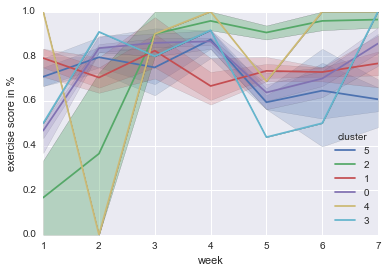

In [146]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

# combine the raw data frame with the group id's discovered by the clustering
clustered_data=df_w.merge(learner2group_dtw, on='course_learner_id')
print clustered_data.head(10)

##setup styles
# sns.set(style="darkgrid")

## the old factorplot with lines
# ax = sns.factorplot(x="rel_week", y="score", hue="group", data=clustered_data, size=8, aspect=1.5)
## and with boxes
# ax = sns.factorplot(kind="box", x="rel_week", y="score", col="group", data=clustered_data, size=8, aspect=1.5)

## time series plot with error bands
# errstyles={'ci_band', 'ci_bars', 'boot_traces', 'boot_kde', 'unit_traces', 'unit_points'}.
ax = sns.tsplot(time="rel_week", unit="course_learner_id", value="score", condition="cluster", 
                 data=clustered_data, err_style={'ci_band'}, ci=[70, 99], interpolate=True)
ax.set(xlabel='week', ylabel='exercise score in %')
# plt.title(coursetitle+": Passer Group " + str(group))
plt.show()


ax.get_figure().savefig(outputfolderpath + coursetitle + "_grade_clust_dtw_" + group + ".png")



## that the old matplotlib version for visualization
#for i in range(0, best_n_clusters):
    #clustered_data[clustered_data['cluster']==i].drop('cluster',1).boxplot(by ='rel_week', figsize=(15,8))